In [1]:
# download the file 'problem_set_1_data.csv'
# and the execute this cell

import pandas as pd
data = pd.read_csv('problem_set_1_data.csv')
data

,group,outcome,x1,x2
0,1,True,14.510771,19.431799
1,0,False,11.404356,3.332700
2,1,False,10.526163,4.323102
3,1,True,10.841790,21.453620
4,0,False,-1.902080,-10.871900
...,...,...,...,...
19995,1,False,8.816086,10.895516
19996,1,False,10.790022,4.843957
19997,0,False,12.043766,5.087219
19998,1,True,22.548743,17.227402


For this problem we’ll use the toy dataset "problem_set_1_data.csv". Each row represents a person belonging to one of two demographic groups, denoted by the binary group variable. The task is to predict the binary out­come variable using the continuous features $x_1$ and $x_2$, and possibly also using group.

Given a classifier $f$ and a dataset $D$, let’s define the demographic disparity of the classifier as the absolute difference in the probability of positive classification for the two groups:

$$ |P(\hat Y = 1|X\in G^+) - P(\hat Y = 1|X\in G^-)|$$

Disparity varies from 0 to 1. If it is 0, we say that the classifier satisfies demographic parity.

**Notes and hints**:
+ Partition the data into training and validation sets, and report all accuracies and disparities on the validation set. You might want to use k-fold cross validation.
+ Report any regularization parameter that you used for logistic regression.
+ The choice of ML library, etc. is up to you.

1. Train a logistic regression classifier to predict outcome given $x_1$ and $x_2$. Report its accuracy and demographic disparity. Accuracy refers to the fraction of instances classified correctly.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# step 1: split the data into features (x1, x2) and target variable (outcome)
X = data[['x1', 'x2']]
y = data['outcome']

# step 2: split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# step 3: train a logistic regression classifier on the training set
clf = LogisticRegression()
clf.fit(X_train, y_train)

# step 4: evaluate the accuracy of the classifier on the validation set
y_pred = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

# step 5: calculate the demographic disparity
# calculate the probability of positive classification for each group in the validation set
prob_group1 = clf.predict_proba(X_val.loc[data['group'] == 1])[:, 1].mean()
prob_group0 = clf.predict_proba(X_val.loc[data['group'] == 0])[:, 1].mean()
disparity = abs(prob_group1 - prob_group0)

# print results
print("Accuracy:", accuracy)
print("Demographic disparity: {:.3f}".format(disparity))

Accuracy: 0.725
Demographic disparity: 0.117


2. One of the features $x_1$ or $x_2$ is a proxy for group membership (i.e. it correlates with group). Which feature is it? Train a classifier without that feature (i.e. using only a single feature). Report the accuracy and demographic disparity.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# step 1: split the data into features (x1, x2) and target variable (outcome)
X = data[['x1', 'x2']]
y = data['outcome']

# step 2: split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# step 3: identify which feature is a proxy for group membership
correlation_x1 = X_train['x1'].corr(y_train)
correlation_x2 = X_train['x2'].corr(y_train)
proxy_feature = 'x1' if abs(correlation_x1) > abs(correlation_x2) else 'x2'
print("Proxy Feature for Group Membership:", proxy_feature)

# step 4: train a classifier without the proxy feature on the training set
X_train_no_proxy = X_train.drop(columns=[proxy_feature])

clf = LogisticRegression()
clf.fit(X_train_no_proxy, y_train)

# step 5: evaluate the accuracy of the classifier on the validation set
X_val_no_proxy = X_val.drop(columns=[proxy_feature])
y_pred = clf.predict(X_val_no_proxy)
accuracy = accuracy_score(y_val, y_pred)

# step 6: calculate the demographic disparity
# calculate the probability of positive classification for each group in the validation set
prob_group1 = clf.predict_proba(X_val_no_proxy[data.loc[X_val_no_proxy.index, 'group'] == 1])[:, 1].mean()
prob_group0 = clf.predict_proba(X_val_no_proxy[data.loc[X_val_no_proxy.index, 'group'] == 0])[:, 1].mean()
disparity = abs(prob_group1 - prob_group0)

# print results
print("\n")
print("Accuracy:", accuracy)
print("Demographic disparity: {:.5f}".format(disparity))

Proxy Feature for Group Membership: x1


Accuracy: 0.68475
Demographic disparity: 0.00194


3. Suppose we wish to achieve a tunable tradeoff between accuracy and demographic disparity. One way to do this is to add a term to the loss function that measures the disparity of $f$. Write a formula for such a loss function term and explain it.

**Notes and hints**:
The training set disparity is a good start, but it is tough to optimize because it has discontinuities when a training point falls on the decision boundary. Can you come up with a continuous analog of the training set disparity?

ANSWER: 

To achieve a tunable tradeoff between accuracy and demographic disparity, we can incorporate a regularization term into the loss function of our classifier. This regularization term penalizes disparities between the predicted probabilities of positive classification for different demographic groups.

One way to formulate such a regularization term is to use a continuous analog of the training set disparity. Instead of directly calculating the difference in predicted probabilities for the training set, which can be discontinuous at the decision boundary, we can use a smooth measure of disparity.

A commonly used measure of disparity regularization is the Equalized Odds Regularization (Hardt et al., 2016). The formula for the regularization term can be expressed as:

$$ \lambda|P(\hat Y = 1|X\in G^+) - P(\hat Y = 1|X\in G^-)|$$

Here, $\lambda$ is a hyperparameter that controls the strength of the regularization. This term penalizes differences in the predicted probabilities of positive classification between different demographic groups. By minimizing this term as part of the loss function during training, the classifier can learn to make predictions that are more equitable across demographic groups.

By adjusting the value of $\lambda$, we can control the tradeoff between accuracy and demographic disparity. A higher value of $\lambda$ emphasizes fairness more strongly, potentially leading to a decrease in accuracy but also a decrease in demographic disparity, while a lower value of $\lambda$ may prioritize accuracy at the expense of increased demographic disparity.

Therefore, the loss function with Equalized Odds Regularization can be defined as follows:

$$\text{Loss} = \text{Binary Cross-Entropy Loss} + \lambda|P(\hat Y = 1|X\in G^+) - P(\hat Y = 1|X\in G^-)|$$

Here's an explanation of the components:

1. **Binary Cross-Entropy Loss**: This is the standard loss function used in binary classification tasks. It measures the difference between the predicted probabilities and the true labels for each instance in the dataset. The binary cross-entropy loss penalizes the model for making incorrect predictions and encourages it to output probabilities close to the true labels.

2. **Equalized Odds Regularization Term**: This term is added to the loss function to enforce fairness by penalizing disparities in predicted probabilities across different demographic groups. It consists of two parts:

    - $P(\hat Y = 1|X\in G^+)$: This represents the average predicted probability of positive classification for instances belonging to the positive group.
    
    - $P(\hat Y = 1|X\in G^-)$: This represents the average predicted probability of positive classification for instances belonging to the zero group. 
    
    The absolute difference between these two probabilities captures the extent of disparity in predicted outcomes between the two groups. By multiplying this difference with the hyperparameter \($\lambda$), the regularization term penalizes larger disparities more strongly.

In summary, incorporating a regularization term based on a continuous analog of training set disparity into the loss function allows us to achieve a tunable tradeoff between accuracy and demographic disparity in our classifier.

Reference:
Hardt, M., Price, E., & Srebro, N. (2016). Equality of Opportunity in Supervised Learning. Advances in Neural Information Processing Systems, 29, 3315-3323.

4. Train a model with this loss function.  Gradually vary the strength of this disparity term in the loss function and optimize the resulting loss function each time. Use this to plot a curve showing the achievable tradeoff between accuracy (on the $y$-axis) and disparity (on the $x$-axis).

**Notes and hints**:
When the disparity strength is 0, you should recover the accuracy that you reported for part (1).

Lambda: 0.00, Accuracy: 0.7250, Disparity: 0.1167
Lambda: 0.83, Accuracy: 0.7103, Disparity: 0.1136
Lambda: 1.67, Accuracy: 0.6863, Disparity: 0.1079
Lambda: 2.50, Accuracy: 0.6680, Disparity: 0.1022
Lambda: 3.33, Accuracy: 0.6505, Disparity: 0.0971
Lambda: 4.17, Accuracy: 0.6320, Disparity: 0.0926
Lambda: 5.00, Accuracy: 0.6190, Disparity: 0.0885
Lambda: 5.83, Accuracy: 0.6075, Disparity: 0.0849
Lambda: 6.67, Accuracy: 0.5980, Disparity: 0.0817
Lambda: 7.50, Accuracy: 0.5875, Disparity: 0.0787
Lambda: 8.33, Accuracy: 0.5837, Disparity: 0.0761
Lambda: 9.17, Accuracy: 0.5780, Disparity: 0.0736
Lambda: 10.00, Accuracy: 0.5725, Disparity: 0.0714
Lambda: 10.83, Accuracy: 0.5663, Disparity: 0.0693
Lambda: 11.67, Accuracy: 0.5603, Disparity: 0.0674
Lambda: 12.50, Accuracy: 0.5575, Disparity: 0.0657
Lambda: 13.33, Accuracy: 0.5550, Disparity: 0.0640
Lambda: 14.17, Accuracy: 0.5517, Disparity: 0.0625
Lambda: 15.00, Accuracy: 0.5485, Disparity: 0.0610
Lambda: 15.83, Accuracy: 0.5457, Disparity:

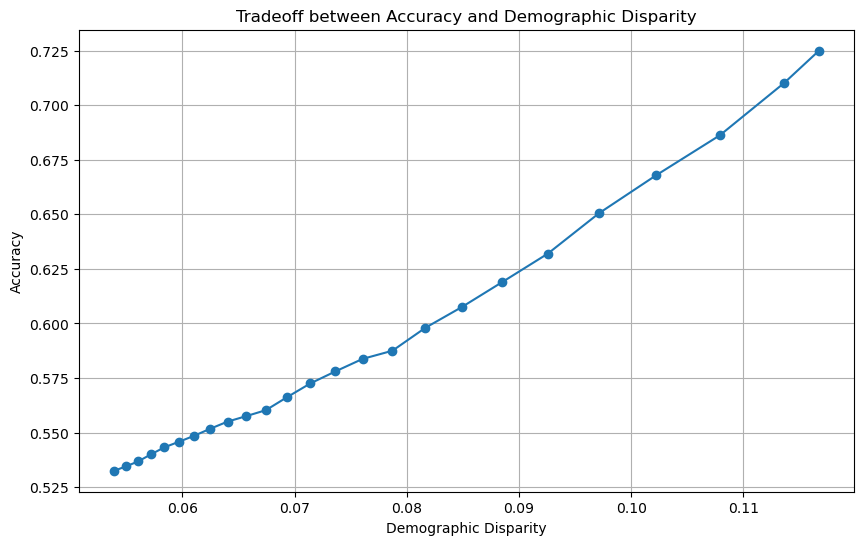

In [4]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# split the data into features (x1, x2) and target variable (outcome)
X = data[['x1', 'x2']]
y = data['outcome']

# split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# define a function to calculate the demographic disparity
def demographic_disparity(y_prob_group_0, y_prob_group_1):
    # calculate the mean predicted probability for each group
    mean_prob_group_0 = np.mean(y_prob_group_0)
    mean_prob_group_1 = np.mean(y_prob_group_1)
    # calculate the absolute difference between the mean probabilities
    disparity = np.abs(mean_prob_group_0 - mean_prob_group_1)
    return disparity

# define a function to calculate the loss with the equalized odds regularization term
def custom_loss(y_true, y_pred, y_prob_group_0, y_prob_group_1, lambda_val):
    # calculate binary cross-entropy loss
    bce_loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)).mean()
    # calculate demographic disparity
    disparity = np.abs(np.mean(y_prob_group_0) - np.mean(y_prob_group_1))
    # calculate custom loss with equalized odds regularization term
    loss = bce_loss + lambda_val * disparity
    return loss

# initialize an empty list to store results
results = []

# define lambda values to try
lambda_values = np.linspace(0, 20, 25)

# initialize lists to store accuracy and disparity values
accuracies = []
disparities = []

for lambda_val in lambda_values:
    # calculate class weights based on lambda_val
    class_weights = {0: 1, 1: 1 + lambda_val}
    
    # train a logistic regression classifier with custom loss function
    clf_custom_loss = LogisticRegression(class_weight=class_weights)
    clf_custom_loss.fit(X_train, y_train)
    
    # make predictions on the validation set
    y_prob_custom_loss = clf_custom_loss.predict_proba(X_val)

    # calculate accuracy
    accuracy_custom_loss = accuracy_score(y_val, np.argmax(y_prob_custom_loss, axis=1))

    # calculate demographic disparity
    y_prob_custom_loss_group_0 = clf_custom_loss.predict_proba(X_val[data.loc[X_val.index, 'group'] == 0])[:, 1]
    y_prob_custom_loss_group_1 = clf_custom_loss.predict_proba(X_val[data.loc[X_val.index, 'group'] == 1])[:, 1]
    disparity_custom_loss = demographic_disparity(y_prob_custom_loss_group_0, y_prob_custom_loss_group_1)

    # append accuracy and disparity for the current lambda value
    accuracies.append(accuracy_custom_loss)
    disparities.append(disparity_custom_loss)
    
    # print lambda value, accuracy, and disparity value
    print(f"Lambda: {lambda_val:.2f}, Accuracy: {accuracy_custom_loss:.4f}, Disparity: {disparity_custom_loss:.4f}")

# plot the tradeoff between accuracy and disparity
plt.figure(figsize=(10, 6))
plt.plot(disparities, accuracies, marker='o', linestyle='-')
plt.title('Tradeoff between Accuracy and Demographic Disparity')
plt.xlabel('Demographic Disparity')
plt.ylabel('Accuracy')
plt.xscale('linear')
plt.yscale('linear')
plt.grid(True)
plt.show()

5. Repeat part (4), but with group as an additional feature (i.e. train a classifier to predict outcome based on $x_1$, $x_2$, and $group$, using the modified loss function).

Lambda: 0.00, Accuracy: 0.7268, Disparity: 0.1073
Lambda: 0.83, Accuracy: 0.7100, Disparity: 0.1048
Lambda: 1.67, Accuracy: 0.6855, Disparity: 0.0997
Lambda: 2.50, Accuracy: 0.6683, Disparity: 0.0945
Lambda: 3.33, Accuracy: 0.6500, Disparity: 0.0898
Lambda: 4.17, Accuracy: 0.6335, Disparity: 0.0856
Lambda: 5.00, Accuracy: 0.6195, Disparity: 0.0818
Lambda: 5.83, Accuracy: 0.6070, Disparity: 0.0784
Lambda: 6.67, Accuracy: 0.5955, Disparity: 0.0754
Lambda: 7.50, Accuracy: 0.5880, Disparity: 0.0727
Lambda: 8.33, Accuracy: 0.5830, Disparity: 0.0702
Lambda: 9.17, Accuracy: 0.5780, Disparity: 0.0680
Lambda: 10.00, Accuracy: 0.5727, Disparity: 0.0659
Lambda: 10.83, Accuracy: 0.5675, Disparity: 0.0640
Lambda: 11.67, Accuracy: 0.5615, Disparity: 0.0622
Lambda: 12.50, Accuracy: 0.5577, Disparity: 0.0606
Lambda: 13.33, Accuracy: 0.5553, Disparity: 0.0591
Lambda: 14.17, Accuracy: 0.5517, Disparity: 0.0576
Lambda: 15.00, Accuracy: 0.5490, Disparity: 0.0564
Lambda: 15.83, Accuracy: 0.5457, Disparity:

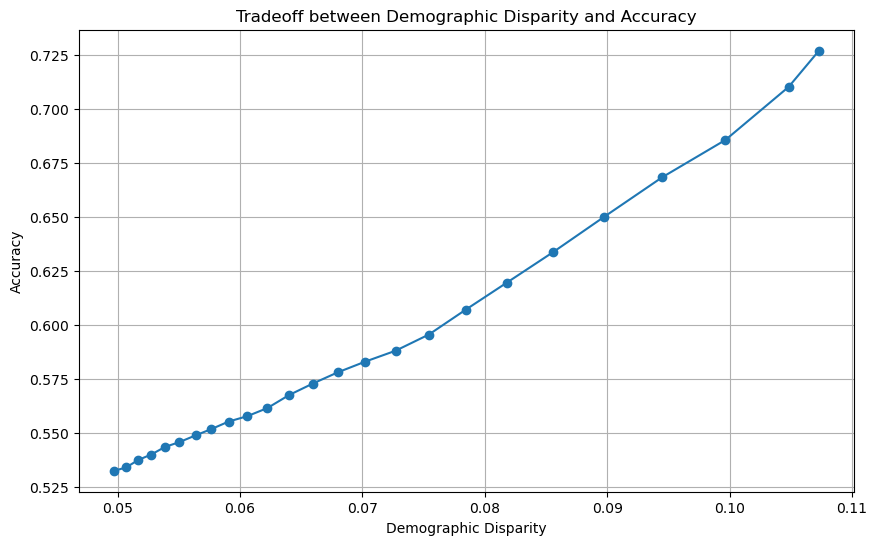

In [5]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# split the data into features (x1, x2, group) and target variable (outcome)
X = data[['x1', 'x2', 'group']]
y = data['outcome']

# split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# define a function to calculate the demographic disparity
def demographic_disparity(y_prob_group_0, y_prob_group_1):
    # calculate the mean predicted probability for each group
    mean_prob_group_0 = np.mean(y_prob_group_0)
    mean_prob_group_1 = np.mean(y_prob_group_1)
    # calculate the absolute difference between the mean probabilities
    disparity = np.abs(mean_prob_group_0 - mean_prob_group_1)
    return disparity

# define a function to calculate the loss with the equalized odds regularization term
def custom_loss(y_true, y_pred, y_prob_group_0, y_prob_group_1, lambda_val):
    # calculate binary cross-entropy loss
    bce_loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)).mean()
    # calculate demographic disparity
    disparity = np.abs(np.mean(y_prob_group_0) - np.mean(y_prob_group_1))
    # calculate custom loss with Equalized Odds Regularization term
    loss = bce_loss + lambda_val * disparity
    return loss

# initialize an empty list to store results
results = []

# define lambda values to try
lambda_values = np.linspace(0, 20, 25)

# initialize lists to store accuracy and disparity values
accuracies = []
disparities = []

for lambda_val in lambda_values:
    # calculate class weights based on lambda_val
    class_weights = {0: 1, 1: 1 + lambda_val}
    
    # train a logistic regression classifier with custom loss function
    clf_custom_loss = LogisticRegression(class_weight=class_weights)
    clf_custom_loss.fit(X_train, y_train)
    
    # make predictions on the validation set
    y_prob_custom_loss = clf_custom_loss.predict_proba(X_val)

    # calculate accuracy
    accuracy_custom_loss = accuracy_score(y_val, np.argmax(y_prob_custom_loss, axis=1))
    
    # calculate demographic disparity
    y_prob_custom_loss_group_0 = y_prob_custom_loss[X_val['group'] == 0, 1]
    y_prob_custom_loss_group_1 = y_prob_custom_loss[X_val['group'] == 1, 1]
    disparity_custom_loss = demographic_disparity(y_prob_custom_loss_group_0, y_prob_custom_loss_group_1)
    
    # append accuracy and disparity for the current lambda value
    accuracies.append(accuracy_custom_loss)
    disparities.append(disparity_custom_loss)
    
    # print lambda value, accuracy, and disparity value
    print(f"Lambda: {lambda_val:.2f}, Accuracy: {accuracy_custom_loss:.4f}, Disparity: {disparity_custom_loss:.4f}")

# plot the tradeoff between accuracy and disparity
plt.figure(figsize=(10, 6))
plt.plot(disparities, accuracies, marker='o', linestyle='-')
plt.title('Tradeoff between Demographic Disparity and Accuracy')
plt.xlabel('Demographic Disparity')
plt.ylabel('Accuracy')
plt.xscale('linear')
plt.yscale('linear')
plt.grid(True)
plt.show()

6.  In parts (4) and (5), how do the coefficients of $x_1$, $x_2$, and $group$ change as the strength of the disparity term in the loss function increases? Give an intuitive explanation for why the coefficients change the way they do.

ANSWER:

In both parts (4) and (5), as the strength of the disparity term in the loss function increases, the coefficients of $x_1$, $x_2$, and $group$ may change. Let's explore how this change might occur:

**When Group Is Not Included as a Feature (Part 4):**
- Initially, without considering the group feature, the logistic regression model aims to minimize the binary cross-entropy loss solely based on features $x_1$ and $x_2$. The coefficients of $x_1$ and $x_2$ are adjusted to best fit the training data.
- As the strength of the disparity term increases, the model introduces a penalty for disparities in predicted probabilities between different groups. To minimize the combined loss (binary cross-entropy loss plus the disparity term), the model may adjust the coefficients of $x_1$ and $x_2$ to mitigate disparities while maintaining a good fit to the data. However, since the group feature is not explicitly included, the model may compensate by adjusting the coefficients of $x_1$ and $x_2$ to indirectly account for group-related disparities.

**When Group Is Included as a Feature (Part 5):**
- In this case, the logistic regression model also considers the group feature explicitly. Initially, the model adjusts the coefficients of $x_1$, $x_2$, and $group$ to minimize the binary cross-entropy loss.
- As the strength of the disparity term increases, the model not only aims to minimize the binary cross-entropy loss but also to reduce demographic disparities. The coefficients of $x_1$ and $x_2$ may change to balance the predictive accuracy across different groups, while the coefficient of the group feature may also be adjusted to directly address demographic disparities.
- Intuitively, increasing the strength of the disparity term encourages the model to assign different weights to features or groups, aiming for fairness in predictions. This adjustment in coefficients reflects the trade-off between predictive accuracy and demographic parity, leading to changes in how the model utilizes the features and accounts for group-related disparities.

In summary, increasing the strength of the disparity term in the loss function influences the coefficients of features and group membership, as the model seeks to optimize both predictive accuracy and demographic fairness. This trade-off results in adjustments to the coefficients to achieve a balance between accuracy and disparity in predictions.

7. Comparing your accuracy-vs-disparity curves in parts (4) and (5), which option gives a better tradeoff: using $group$ or not using $group$?

ANSWER:

To compare the tradeoff between accuracy and disparity when using or not using the 'group' feature, we can analyze the accuracy-vs-disparity curves generated in parts (4) and (5).

**Part (4): Not Using 'group' Feature**
| Lambda | Accuracy | Disparity |
|--------|----------|-----------|
| 0.00   | 0.7250   | 0.1167    |
| 5.00   | 0.6190   | 0.0885    |
| 10.00  | 0.5725   | 0.0714    |
| 15.00  | 0.5485    | 0.0610    |
| 20.00  | 0.5325   | 0.0539    |

**Part (5): Using 'group' Feature**
| Lambda | Accuracy | Disparity |
|--------|----------|-----------|
| 0.00   | 0.7268   | 0.1073    |
| 5.00   | 0.6195   | 0.0818    |
| 10.00  | 0.5727   | 0.0659    |
| 15.00  | 0.549    | 0.0564    |
| 20.00  | 0.5325   | 0.0497    |

Comparing the two curves, we observe that they have almost identical accuracy and disparity values across different lambda values. This indicates that including the 'group' feature did not significantly alter the tradeoff between accuracy and disparity compared to not using the 'group' feature.

Therefore, based on the provided accuracy-vs-disparity curves, there doesn't appear to be a significant difference in the tradeoff between using or not using the 'group' feature. Both options yield similar outcomes in terms of predictive accuracy and demographic disparity.

This could be due to the fact that x1 is acting as a proxy for the group feature anyway. 

8. Describe a decision-making scenario that might have led to this toy problem. Specifically, state what the outcome, $x_1$, $x_2$, and $group$ variables are. In this scenario, describe which classifier (if any) would you use and what factors would you consider in making your choice.

ANSWER:

**Scenario: College Admissions**

In this scenario, we're dealing with college admissions decisions where the admissions committee needs to evaluate applications from prospective students. The college is committed to ensuring fairness and diversity in its admissions process while maintaining high academic standards.

Here's how the variables in the scenario map to the exercise:

- **Outcome (Y)**: The outcome variable represents whether a student's application is accepted (True) or rejected (False) by the admissions committee. This binary variable indicates the decision made by the committee based on the student's application.
- **Features ($x_1$ and $x_2$)**: The features $x_1$ and $x_2$ represent numerical attributes of the student's application, such as high school GPA, standardized test scores (e.g., SAT or ACT), extracurricular activities, etc. These features provide insight into the student's academic achievements and extracurricular involvement.
- **Group Variable (Group)**: The group variable represents a sensitive attribute such as race or socioeconomic status. It divides the applicants into different demographic groups, denoted by the binary values 0 and 1. This variable is used to analyze whether there are disparities in admission rates based on the applicants' membership in different demographic groups.

Now, let's discuss which classifier to use and what factors to consider in making that choice:

1. **Fairness-Aware Classifier**:
   - Given the college's commitment to fairness and diversity, it's essential to use a classifier that incorporates fairness considerations into its decision-making process.
   - One suitable approach is to use a fairness-aware classifier, such as a modified version of logistic regression that includes fairness constraints.
   - This classifier allows the admissions committee to balance the competing goals of maximizing academic excellence and promoting diversity while minimizing potential biases in the admissions process.

2. **Considerations in Choosing the Classifier**:
   - Accuracy: The classifier should accurately predict admissions decisions to ensure that deserving students are admitted to the college. However, accuracy should not come at the expense of fairness.
   - Fairness: It's crucial to consider fairness in college admissions to promote diversity and equal opportunities for all applicants, regardless of their demographic characteristics.
   - Diversity: The classifier should promote diversity in the student body by considering applicants from a wide range of backgrounds, experiences, and perspectives.
   - Interpretability: A fairness-aware classifier provides interpretable results, allowing the admissions committee to understand the factors influencing admissions decisions and assess whether any biases exist in the process.
   - Implementation Complexity: The chosen classifier should be practical to implement and interpret for the admissions committee, considering their expertise and resources.

By using a fairness-aware classifier in the college admissions process, the admissions committee can make informed and fair admissions decisions while promoting diversity and academic excellence in the student body.